In [18]:
%load_ext line_profiler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import preprocessing
import sklearn.linear_model as lm
import src.random_matrix as rm
import src.stat_arb as sa
import src.dim_reduction as dr
import statsmodels.api as sm
import math
import importlib

PATH = '/data/hawfinch/clarkson/data/us_eq/cache'

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [335]:
df = pd.read_pickle('{}/log_returns_cleaned.pkl'.format(PATH))

df = df.dropna(thresh=len(df)*.99, axis=1)
df = df.dropna(axis=0)
spy = df['SPY']
df = df.drop('SPY', axis=1)

df_excess = df.apply(lambda x: x - spy)
df_excess

ticker,AA,AABA,AAON,AAPL,ABC,ABCB,ABM,ABMD,ABT,ACHC,...,ZBRA,ZEUS,ZION,ZIXI,PKG,SNH,UTSI,SLAB,EPC,EW
date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0.012937,-0.097531,-0.029607,-0.024211,0.003142,-0.001034,-0.048365,-0.046907,0.028059,-0.048287,...,-0.020812,-0.063554,-0.006948,-0.058037,-0.001034,0.023967,-0.062150,0.043571,-0.001034,-0.004932
2000-03-30,0.009640,-0.026769,0.045454,-0.061019,-0.017021,0.023111,0.014326,-0.125017,0.034643,-0.049811,...,-0.019996,0.048629,-0.014039,-0.151571,0.016881,0.016881,0.006961,-0.074411,-0.004397,-0.022965
2000-03-31,-0.031043,-0.000284,-0.021905,0.065694,0.022616,-0.011285,-0.050404,0.049146,-0.020127,0.022616,...,0.024342,-0.011285,0.071639,-0.049185,0.056433,0.000985,-0.054379,0.029066,-0.013977,-0.136720
2000-04-03,0.012837,-0.073701,-0.009367,-0.024381,-0.031120,-0.012033,0.010030,-0.062960,0.044425,-0.188123,...,-0.047927,-0.037551,-0.045623,-0.134806,-0.023820,-0.018072,-0.121985,-0.195780,-0.093058,0.007928
2000-04-04,-0.007191,0.051748,0.021651,-0.038586,0.069598,0.032158,-0.027158,-0.015676,0.071265,0.189787,...,-0.004338,0.007466,0.047287,-0.144084,-0.017075,0.019736,-0.224258,0.058247,0.010403,0.025484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-17,-0.012916,-0.028874,-0.002189,0.000788,0.008289,-0.000994,-0.006112,0.000133,-0.001772,0.011358,...,-0.052587,0.007190,-0.003881,-0.024252,0.001747,-0.003378,0.009521,-0.021766,-0.024588,-0.016469
2019-05-20,-0.014402,-0.048323,0.024551,-0.025135,0.025748,0.006356,-0.003721,-0.024164,0.003998,0.002372,...,-0.026571,-0.011103,0.002190,0.033038,-0.040407,-0.013392,-0.017907,-0.026555,0.000679,0.004668
2019-05-21,0.021809,0.005509,0.015957,0.010014,0.007796,0.001815,0.001643,0.021285,-0.005550,0.010660,...,0.018463,0.031704,0.010434,-0.001404,0.014452,-0.003931,-0.021475,0.023794,0.004142,-0.013500


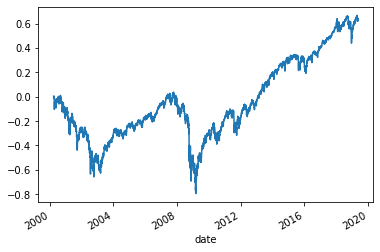

In [336]:
spy.cumsum().plot()

Registered SPca_k=59_60
Registered Corr_pca_60
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000


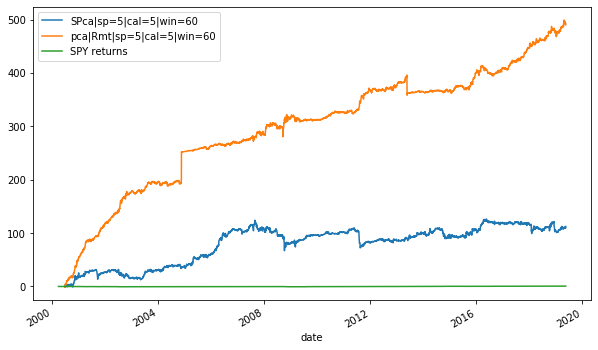

In [431]:
importlib.reload(dr)
importlib.reload(sa)
    
def backtest(df_lr, strats, df_exc=None, benchmark=None):    
    i = 0
    tfmrs = sa.Transforms()
    for strat in strats:
        strat.register_transforms(tfmrs)
        strat.setup(df_lr)
    for index, row in df_lr.iterrows():
        for strat in strats:
            strat.calibrate_portfolio(df_lr, index, tfmrs)
        i += 1
        if i % 1000 == 0: print('Iteration: {}'.format(i))

    for strat in strats:
        strat.pnl_reconciliation(df_lr)
    rets = [strat.cum_ret for strat in strats]
    rets = pd.concat(rets, axis=1) # * benchmark.std()
    rets.plot(figsize=(10,6))
    plt.savefig('last_run.png')
    if benchmark is not None:
        benchmark.cumsum().plot(label='SPY returns')
    plt.legend()

strats = [sa.StArbFm(dr.SPca(k=59), cal_freq=5, window_len=60),
# strats = [sa.StArbFm(dr.Pca(pct_var=50, corr=True), cal_freq=5, window_len=60), \
#           sa.StArbFm(dr.Pca(pct_var=75, corr=True), cal_freq=5, window_len=60), \
#           sa.StArbFm(dr.Pca(pct_var=95, corr=True), cal_freq=5, window_len=60), \
#           sa.StArbFm(dr.Pca(pct_var=10, corr=True), cal_freq=5, window_len=60),

# #         sa.StArbFm(dr.SPca(pct_var=10), cal_freq=5)]
    sa.StArbFm(dr.Pca(rmt=True, corr=True), cal_freq=5)]

backtest(df, strats, df_excess, benchmark=spy)


In [416]:
for strat in strats:
    print(sharpe_ratio_test(strat.lr))

[SPca|sp=5|cal=5|win=60    0.81
dtype: float64, array([0.00022293])]
[pca|Rmt|sp=5|cal=5|win=60    1.28
dtype: float64, array([0.0002284])]


In [186]:
rand = pd.DataFrame(np.random.normal(size=df.shape), index=df.index, columns=df.columns)
backtest(rand, strats, df_excess, benchmark=spy)

Registered Pca_60
Registered SPca_60
(40, 1025)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 40 is different from 1025)

[0    3.82
dtype: float64, array([0.])]


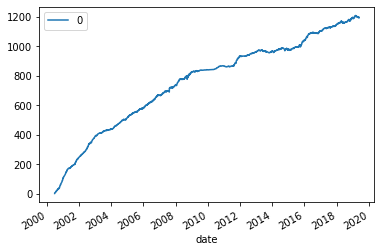

In [24]:
rsp = pd.DataFrame(rsp, index=df.iloc[60:].index)
rsp_daily = (rsp / rsp.ewm(span=252).std().shift(1))
rsp_daily.cumsum().plot()
print(sharpe_ratio_test(rsp_daily))

In [23]:
from scipy.stats import norm

def sharpe_ratio_test(log_ret):
    '''
    Implements the sharpe ratio test ion Opdyke 2007
    :param log_ret: daily log-returns
    :return: annualised sharpe ratio and p-value
    '''
    sharpe = log_ret.mean()/log_ret.std()
    sharpe_annualised = sharpe * np.sqrt(252)    
    T = len(log_ret)
    std = log_ret.std()
    skew = ((log_ret - log_ret.mean()) ** 3).mean()
    kurtosis = ((log_ret - log_ret.mean()) ** 4).mean()    
    sharpe_se = np.sqrt((1 + sharpe ** 2/ 4 * (kurtosis - 1) - sharpe * skew) / T)    
    p_value = 1 - norm.cdf(sharpe/sharpe_se)    
    return [sharpe_annualised.round(2), p_value]

            n_pcs
date             
2000-03-29   97.0
2000-03-30   97.0
2000-03-31   97.0
2000-04-03   97.0
2000-04-04   97.0
...           ...
2019-02-21   62.0
2019-02-22   62.0
2019-02-25   60.0
2019-02-26   60.0
2019-02-27   60.0

[4753 rows x 1 columns]


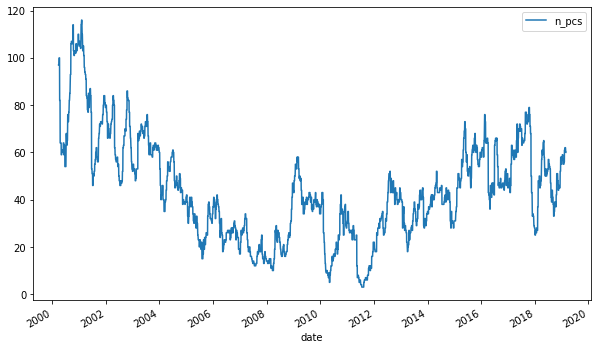

In [415]:
pcs_df = pd.DataFrame(strats[0].n_pcs, index=df.index, columns=['n_pcs'])
print(pcs_df.iloc[:-60])
pcs_df.iloc[:-60].plot(figsize=(10, 6))
# plt.savefig('n_pcs_mp.png')

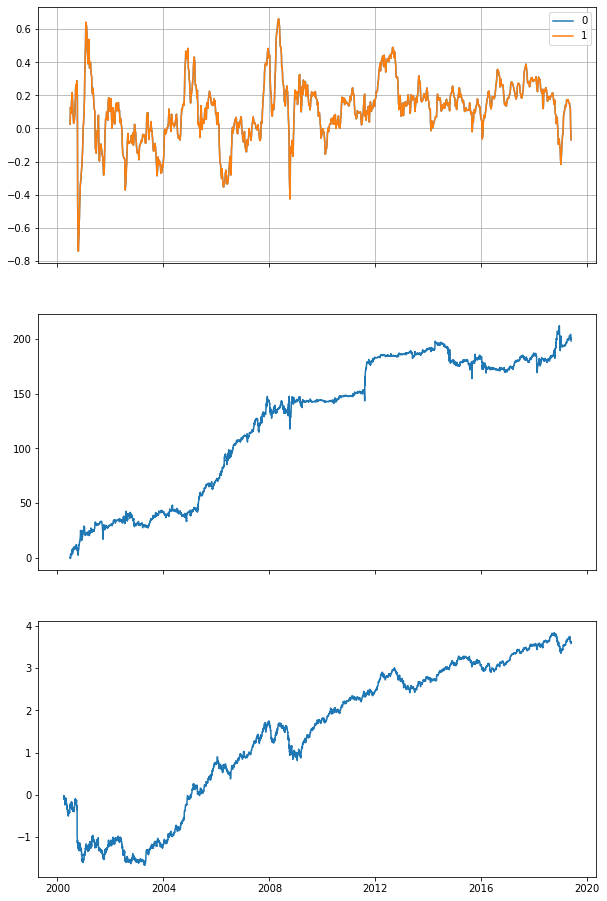

In [429]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 16))
c = strats[1].portfolios['AAPL']
# y = c - c.rolling(60).mean()
ax[0].plot((strats[0].portfolios['AAPL'] * -1).cumsum(), label='0')
# ax[0].plot(((strats[0].portfolios['AAPL'] - strats[0].portfolios['AAPL'].rolling(60).mean())  * -1).cumsum())

ax[0].plot((strats[-1].portfolios['AAPL'] * -1).cumsum(), label='1')
# ax[0].plot((y * -1).cumsum())
ax[1].plot(strats[0].cum_ret)
ax[2].plot(df['AAPL'].cumsum())
ax[0].grid()
ax[0].legend()

The following cell contains code for simulating a dataset to show that the method is able to recover the residual in a simulated case where we know what the residual should be:

In [ ]:
n = df.shape[0]
p = df.shape[1]
residuals = sm.tsa.arma_generate_sample(ar=[1], ma=[1, -0.95], nsample=(n, p))
# residuals = np.random.normal(0,1,size=(n,p))

# Gaussian returns + mean reverting residuals.
test_prices = np.array([np.random.normal(0,1) * np.ones(p) for i in range(n)]) + residuals
test_prices = pd.DataFrame(test_prices, index=df.index, columns=df.columns.values)
test_prices['AAPL'].plot()

In [21]:
# def bt(df_lr, df_exc=None, benchmark=None):
#     pca = PCA(n_components=0.50)
#     returns = np.zeros(len(df_lr))
#     i = 0
#     for index, row in df_lr.iloc[60:].iterrows():
#         ix = df_lr.index.get_loc(index)
#         window = df_lr.iloc[ix-60:ix]
#         fr = pca.fit_transform(window)
#         models = lm.LinearRegression(fit_intercept=False).fit(fr, window)
#         weights = -(window - models.predict(fr)).ewm(span=5).mean().iloc[-1]
#         returns[i] = weights.values.dot(row.values)
#         if i % 500 == 0: print(i)
#         i+= 1
#     return returns
# r = bt(df, df_excess, benchmark=spy)
from scipy import stats

def bt(df_lr, df_exc=None, benchmark=None):
    scaler = StandardScaler()
    pca = PCA(n_components=0.50)
    corr_pca = Pipeline([('s', scaler), ('pca', pca)])
    returns = np.zeros(len(df_lr))
    i = 0
    for index, row in df_lr.iloc[60:].iterrows():
        ix = df_lr.index.get_loc(index)
        window = df_lr.iloc[ix-60:ix]
        win_cen = pd.DataFrame(scale(window, with_mean=True, with_std=False),
                               index=window.index, columns=window.columns.values)
        fr = pca.fit_transform(win_cen)
#         fr = np.matmul(window.values, pca.components_.T)
        models = lm.LinearRegression(fit_intercept=False).fit(fr, win_cen)
        weights = -1 * (win_cen - models.predict(fr)).ewm(span=5).mean().iloc[-1]
        returns[i] = weights.values.dot(row.values)
        if i % 500 == 0: print(i)
        i+= 1
    print('i: {} | len(returns): {}'.format(i, len(returns)))
    return returns[:i]
rsp = bt(df, df_excess, benchmark=spy)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
i: 4753 | len(returns): 4813
